Example taken from https://pytorch.org/tutorials/beginner/nn_tutorial.html

### Download dataset

In [1]:
from pathlib import Path
import requests
import pickle
import gzip

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
# Each image has been stored as a 28x28 = 784 length flattened row
x_train[0].shape

(784,)

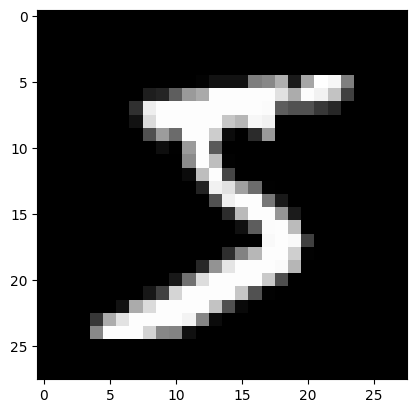

In [6]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
try:
    import google.colab
except ImportError:
    pyplot.show()

In [7]:
# Let's convert numpy arrays into torch Tensors
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### Neural network from scratch

In [8]:
import math

# Initialize the weights with Xavier initialisation by multiplying with 1/sqrt(n)
weights = torch.randn(784, 10) / math.sqrt(784)
# Recall that _ suffix in Pytorch means that the operation is performed in-place
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [9]:
weights

tensor([[ 0.0079, -0.0181, -0.0149,  ..., -0.0452,  0.0056,  0.0319],
        [ 0.0305, -0.0179,  0.0450,  ..., -0.0336,  0.0119, -0.0156],
        [-0.0060,  0.0315,  0.0058,  ...,  0.0572,  0.0226,  0.0388],
        ...,
        [ 0.0224, -0.0128,  0.0165,  ..., -0.0439, -0.0368,  0.0185],
        [-0.0142, -0.0896, -0.0626,  ..., -0.0173,  0.0317, -0.0846],
        [-0.0826,  0.0417,  0.0053,  ..., -0.0416,  0.0035,  0.0320]],
       requires_grad=True)

In [10]:
bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [11]:
# Custom activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [12]:
# Forward pass example
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
print(preds[0], preds.shape)

tensor([-2.2601, -2.6495, -2.3871, -2.8024, -2.4886, -1.8585, -1.8967, -3.1133,
        -1.9972, -2.2706], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [13]:
# Negative log-likelihood loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [14]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2690, grad_fn=<NegBackward0>)


In [15]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

### Training loop

In [16]:
n

50000

In [17]:
(n - 1) // bs + 1

782

In [18]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [19]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0799, grad_fn=<NegBackward0>) tensor(1.)


### Refactor with nn package

In [29]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np

# F.cross_entropy combines both negative log-likelihood and
# log softmax activation function
loss_func = F.cross_entropy

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        # The same would be:
        # self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        # self.bias = nn.Parameter(torch.zeros(10))
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        # The same would be:
        # return xb @ self.weights + self.bias
        return self.lin(xb)

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

def get_data(train_ds, valid_ds, bs):
    # Shuffling the training data is important to prevent correlation
    # between batches and overfitting. On the other hand, the validation
    # loss will be identical whether we shuffle the validation set or not.
    # Since shuffling takes extra time, it makes no sense to shuffle
    # the validation data.

    # We’ll use a batch size for the validation set that is twice as
    # large as that for the training set. This is because the
    # validation set does not need backpropagation and thus takes
    # less memory (it doesn’t need to store the gradients).
    # We take advantage of this to use a larger batch size and
    # compute the loss more quickly.
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    # For the validation set, we don't pass an optimizer
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [30]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3085143205583096
1 0.2864804995715618


### Using nn.Sequential

In [31]:
# Create a custom layer that we'll use in the Sequential
# list to perform the 'view' operation.
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [32]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3050263650923967
1 0.2575970887422562


The above Sequential model has 2 limits:
- it assumes the input is a 28*28 long vector
- it assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)

The first assumption can be avoided by putting the preprocessing logic into the data generator:

In [33]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

The second assumption can be instead removed by replacing nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have:

In [34]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [38]:
%%time
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4025159574508667
1 0.39556985936164857
CPU times: user 9.44 s, sys: 2.35 ms, total: 9.44 s
Wall time: 4.73 s


### Moving to the GPU

In [35]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [38]:
# Move batches to the GPU (if any)
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

# Move the model to the GPU (if any)
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [39]:
%%time
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.6049344713926316
1 0.5646742911338806
CPU times: user 3.45 s, sys: 232 ms, total: 3.68 s
Wall time: 3.68 s
